In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import os.path

In [3]:
# test result function
def frobenius_norm(M1, M2):
    #print M1
    #print M2
    total = 0.0
    for a,b in zip(M1, M2):
        for c, d in zip(a, b):
            total += (c - d)*(c - d)
    return total

In [4]:
# dimension of each example in the dataset
d = 15
# k is the top pricipal calculated by the eigenvectors, right now just fix it
k = 5
# fix the learning rate
learning_rate = 0.00001
# preprocess the data
data_set = []
data_set_done = []
if os.path.exists('new_data_1'):
    with open('new_data_1') as data:
        for line in data:
            data_set_done.append(map(float, line.split()))

else:
    with open('adult.data.txt') as data:
        for line in data:
            # '\s' matches whitespace
            tmp = re.sub(r'\s', '', line).split(',')
            data_set.append(tmp)
    print data_set

    feature_vector_size = len(data_set[0])
    print "feature vector is  " ,feature_vector_size
    print "data set size is ", len(data_set)
    tmp = data_set[0]

    # find out which feature is not a digit
    non_digit_index = []
    for i in range (0,feature_vector_size):
        if tmp[i].isdigit():
            continue
        else:
            non_digit_index.append(i)
    print non_digit_index

    # make each string feature to become a number

    # Copy
    modified_data_set= []
    for item in data_set:
        modified_data_set.append(item)


    print "data before processed dimension is ", len(modified_data_set[0])
    #print modified_data_set
    item_list = []
    count = 0
    dimension_to_increase = 0
    # for all the non_digit index, count how many differnt items
    for i in non_digit_index:
        # clear the item list to find different string for same feature
        items = []
        # loop through the whole data set
        for vector in data_set:
            # get the corresponsding item
            tmp = vector[i]
            # it already in the list
            if tmp in items:
                continue
            else:
                # otherwise append to the list
                items.append(tmp)
        dimension_to_increase = dimension_to_increase + len(items)-1
        #print "item is "
        #print items
        #print "\n\n"
        # loop through the whole data set to replace the feature
        for j in range(len(modified_data_set)):
            v = modified_data_set[j]
            #print v
            # get the item in the vector
            #print "accessing ", i+count
            tmp = v[i+count]
            index  = items.index(tmp)
            front = v[0:i+count]
            end = v[i+1+count:len(v)]
            zeros = [0]*len(items)
            zeros[index] = 1
            front.extend(zeros)
            front.extend(end)
            modified_data_set[j] = front
            #print "result is ", modified_data_set[j]
            #v[i] = float(index)
        count = count + len(items)-1
    for v in modified_data_set:
        v = map(float, v)
        data_set_done.append(v)
    print "dimension to increase ", dimension_to_increase
    print "data processed dimension is ", len(data_set_done[0])
    #print data_set_done
    print "size of data set done is ", len(data_set_done)

f = open('new_data', 'w')
for vector in data_set_done:
    for num in vector:
        f.write(str(num)+" ")
    f.write("\n")
f.close()


In [5]:
# pre-process the data
# find the largest item in the column and divide by that number
d = len(data_set_done[0])
largest = 0.0
largest_list = []

# loop each column and find the largest element
for i in range(0,d):
    largest = 0.0
    for item in data_set_done:
        if item[i] >= largest:
            largest = item[i]
    largest_list.append(largest)

tmp = 0.0
for i in range(0,d):
    tmp = largest_list[i]
    # divide all the items by the largest one to normalize
    for item in data_set_done:
        item[i] = item[i]/tmp
    
f = open('new_data_1', 'w')
for vector in data_set_done:
    for num in vector:
        f.write(str(num)+" ")
    f.write("\n")
f.close()

In [6]:
# helper function to normalize a vector
# v = np.array([[x1,x2]])
def normalizeVector(v):
    distance = 0.0
    for i in v:
        for j in i:
            distance = distance + j**2
    distance = math.sqrt(distance)
    v = v/distance
    return v

# helper function to calculate the distance between two vectors
# v1 = np.array([[x1,x2]])
# v2 = np.array([[x1,x2]])
def distance(v1,v2):
    distance = 0.0
    for i,j in zip(v1,v2):
        for x, y in zip(i, j):
            distance = distance + (x- y)**2
    distance = math.sqrt(distance)
    return distance

# v is np.array([[x1,x2,x3....]])
# v is column-major vector
# the test function compute the sum of distance between X and (v, X)* v
def testFunction(v):
    total = 0.0
    for item in data_set_done:
        tmp = np.array([item])
        dotProduct = np.dot(tmp,v) # dotproduct should be a constant
        dotProduct = dotProduct * v # dotproduct is a column major vector
        total = total + distance(tmp,dotProduct)**2   
    return total

In [7]:
# data set size covariance matrix M
N = len(data_set_done)
M = np.array(data_set_done[0]) * np.transpose(np.array(data_set_done[0])) / N

# M is (sum of data elements * transpose of data element) / size of data
for i in range(1, len(data_set_done)):
    M = M + (np.array([data_set_done[i]]) * np.transpose(np.array([data_set_done[i]]))) / N

U, s, V = np.linalg.svd(M, full_matrices=True)
# U is 110 x 110, s is 110 x 1, V is 110 x 110

In [8]:
X = np.array([U[:,0]])
X.reshape(110,1) #Convert to a correct matrix type for the test function
print "U's base line is ", testFunction(np.transpose(X))

X = np.array([V[0]])
X.reshape(110,1) #Convert to a correct matrix type for the test function
print "V's base line is ", testFunction(np.transpose(X))
baseline = testFunction(np.transpose(X))

U's base line is  837.16382399
V's base line is  837.190526185


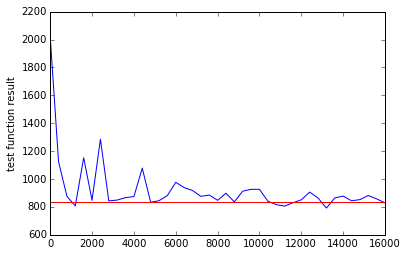

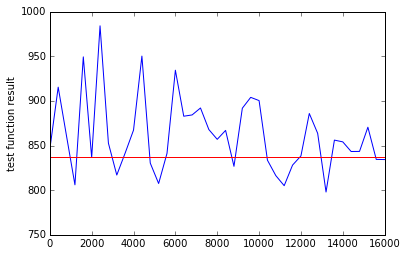

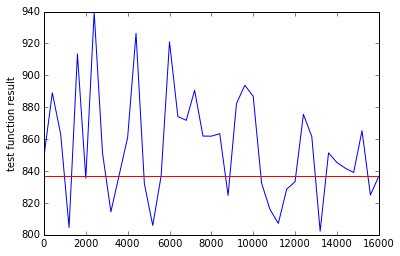

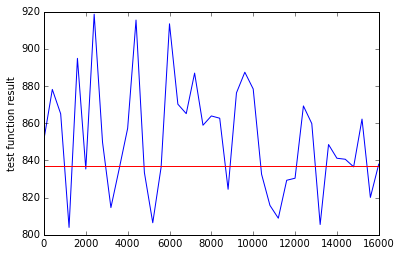

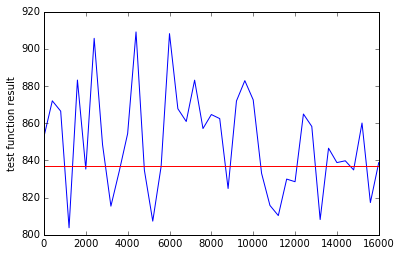

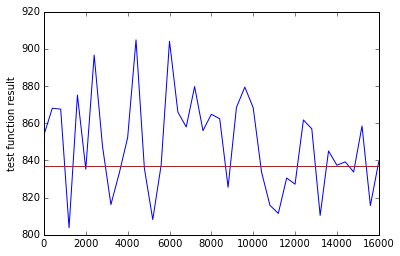

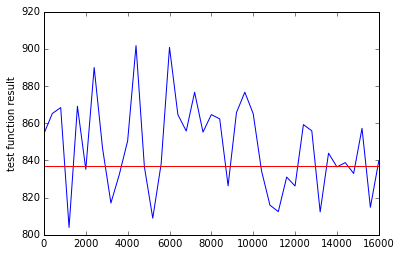

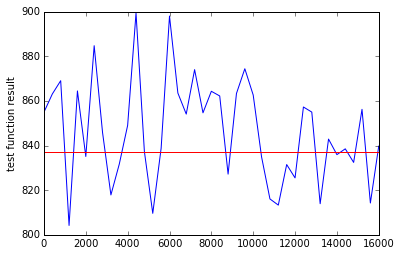

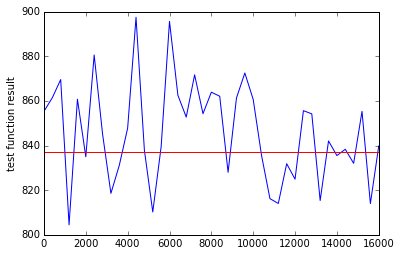

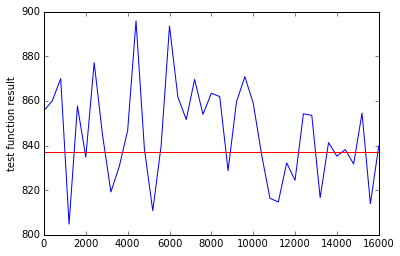

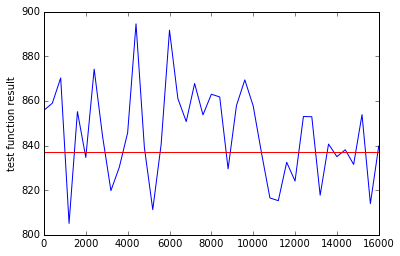

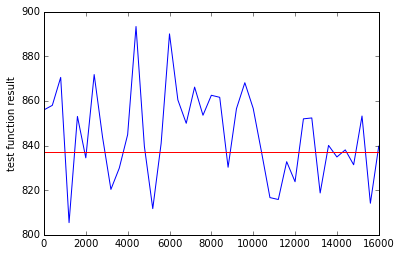

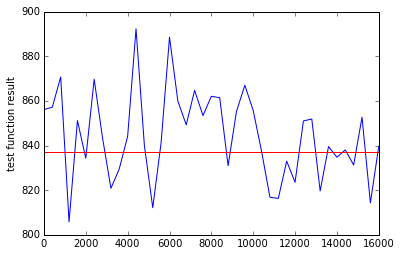

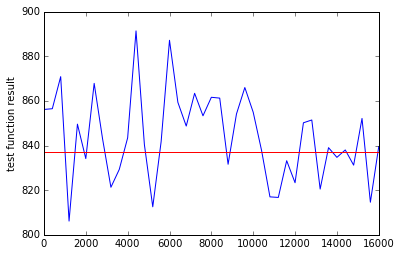

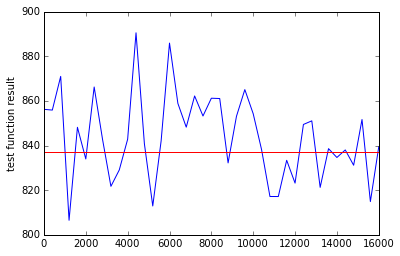

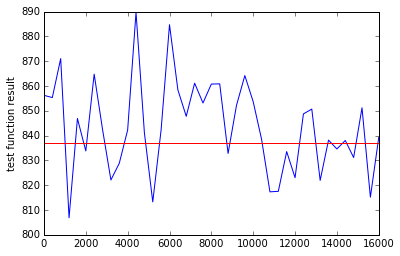

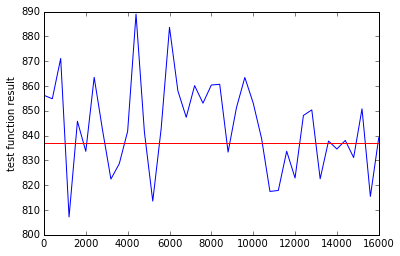

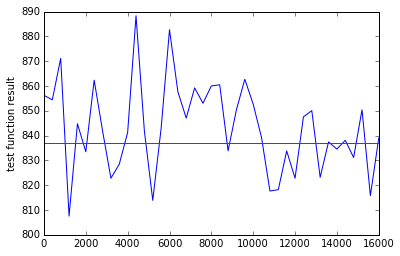

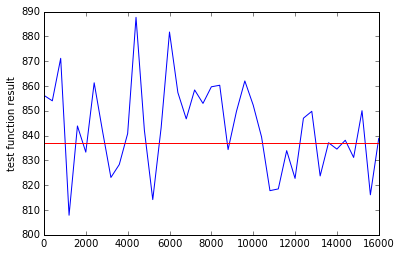

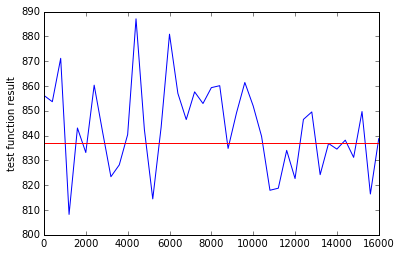

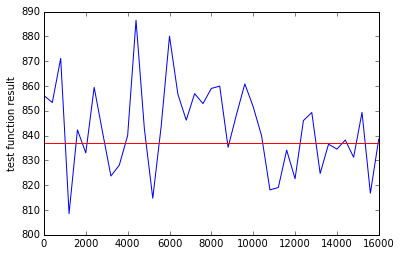

In [9]:
'''
    Implement Oja's rule to find the top k pricipal components of the dataset
'''

# initialize v0 as a vector drawn uniformly at raondom on the surface of a d-dimensional sphere
d = len(data_set_done[0])
v1 = []
prev_v = [] # record the previous v1 to test convergence
s = 0.0
t = len(data_set_done) # t is the data set lenght: how many data points there are
learning_rate = 1.0
# random intialize a vector from a d-dim sphere
for i in range(0,d):
    tmp = np.random.random()
    s = s + tmp**2
    v1.append(tmp)
    prev_v.append(0.0)

s = math.sqrt(s)
# normalize v1 
for i in range(0,d):
    v1[i] = v1[i] * 1.0/ s

a = np.dot(np.array([data_set_done[0]]),np.transpose(np.array([data_set_done[0]])))

dis = 0.0
loop = 0.0
# test convergence
v1 = np.array([v1]) # v1 type np.array([[x1,x2]]) 
v1 = np.transpose(v1) # let v1 becomese a column major vector
prev_v = v1
testResult = []
tPoint = []

# stil have the infinite problem, need to normalize feature
while True:
    testResult = []
    tPoint = []
    #print "loop is ", loop
    for i in range(0, len(data_set_done)/2):
        loop = loop + 1
        learning_rate = 1.0/math.sqrt(loop)
        tmp = data_set_done[i] # convert to right form
        tmp = np.array([tmp])
        b = np.dot(np.transpose(tmp),tmp)
        b = np.dot(b,v1) # result will be a 110 * 1 vector
        v1 = v1 + learning_rate * b 
        v1 = normalizeVector(v1)
        if i % 400 == 0:
            tPoint.append(i)
            test = testFunction(v1)
            testResult.append(test)
    plt.plot(tPoint, testResult, '-')
    plt.axhline(baseline, color='r')
    plt.ylabel('test function result')
    plt.show()
    dis = distance(prev_v,v1)
    if dis <= 0.001:
            break
    prev_v = v1

In [41]:
# put all the data into the new list where each data is subtract with the projection
v1_project = [] 
for i in range(0, len(data_set_done)): 
    v1_project.append(np.array(data_set_done[i]) - np.dot(v1.reshape(1,110)[0], data_set_done[i]) * v1.reshape(1,110))

[[  2.12636287e-003   9.82312817e-001  -9.32367943e-002  -7.40148681e-001
   -2.90927873e-002  -3.63928226e-002  -4.60770267e-002  -2.18273779e-002
   -6.42995664e-005  -1.84495286e-008  -7.31927184e-002   8.55033014e-001
   -3.48745767e-001  -3.32524076e-002  -4.71513034e-002  -2.93070444e-002
   -1.91705186e-001  -3.38312825e-002  -6.72443060e-002  -2.61277230e-002
   -7.06820602e-003  -2.67270048e-002  -3.63293553e-003  -1.64296667e-002
   -2.83076839e-003  -2.05936601e-007  -5.50619741e-003   1.93555435e-001
    6.59147107e-001  -4.48600608e-001  -1.15481955e-001  -1.09964640e-002
   -3.34959539e-002  -2.92224764e-006  -3.50961944e-002   8.99722320e-001
   -1.09822202e-001  -4.67739920e-002  -1.35683056e-001  -7.13331965e-002
   -1.27000961e-001  -1.34859107e-001  -4.58037911e-002  -2.74339530e-002
   -1.02412921e-001  -2.20524104e-002  -4.60770451e-002  -1.29312438e-002
   -1.98602988e-003  -7.94012895e-005   7.14205108e-001  -4.16443096e-001
   -2.68920461e-002  -1.47075582e-001 

In [12]:
'''
 test function 2, need to minises both v1 and v2 in order to compare to baseline 
'''
# v is np.array([[x1,x2,x3....]])
# v is column-major vector
# the test function compute the sum of distance between X and (v, X)* v

def testFunction2(v1,v2):
    total = 0.0
    for item in data_set_done:
        tmp = np.array([item])
        dotProduct = np.dot(tmp,v1) # dotproduct should be a constant
        dotProduct2 = np.dot(tmp,v2)
        
        dotProduct = dotProduct * v1 # dotproduct is a column major vector
        dotProduct2 = dotProduct2 * v2
        result = dotProduct + dotProduct2 # plus them together
        total = total + distance(tmp,result)**2   
    return total

In [13]:
X = np.array([V[0]])
Y = np.array([V[1]])
#print testFunction2(np.transpose(X))
X.reshape(110,1) #Convert to a correct matrix type for the test function
Y.reshape(110,1)
# Need transpose because our test function use row vector instead of column vector
baseline = testFunction2(np.transpose(X), np.transpose(Y))
print "with two eigenvector, the new baseline is ", baseline

with two eigenvector, the new baseline is  803.234732097


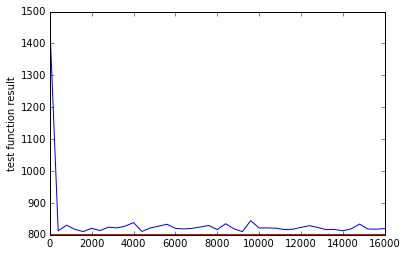

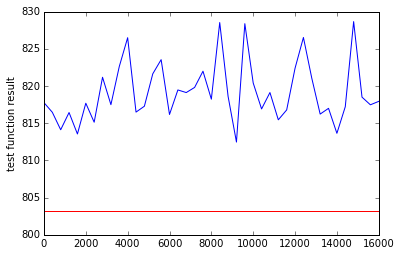

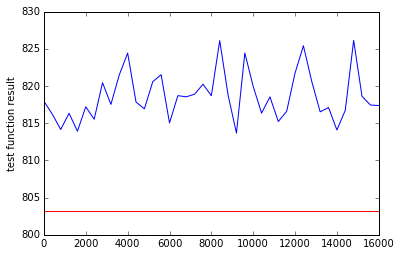

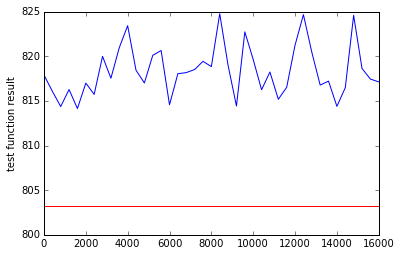

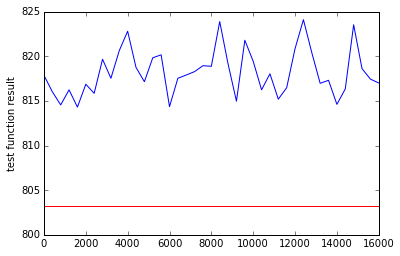

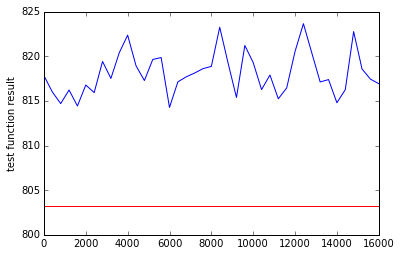

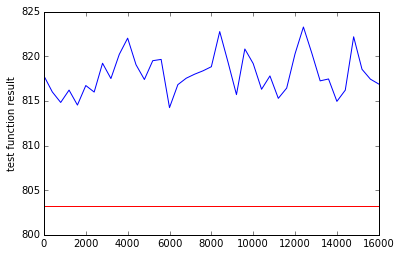

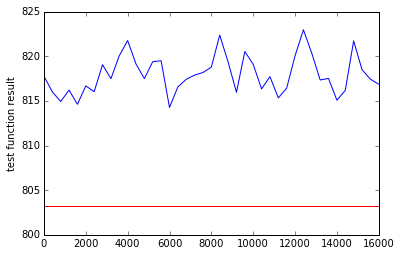

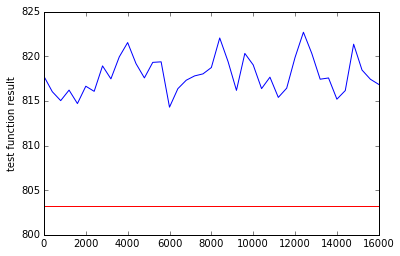

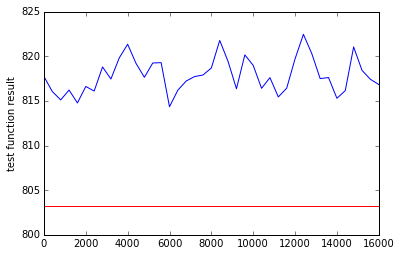

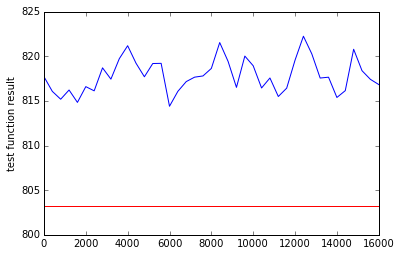

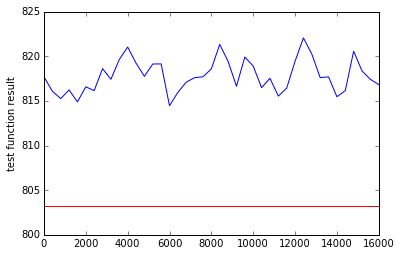

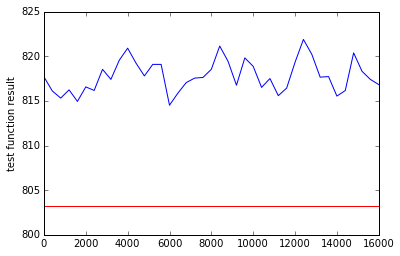

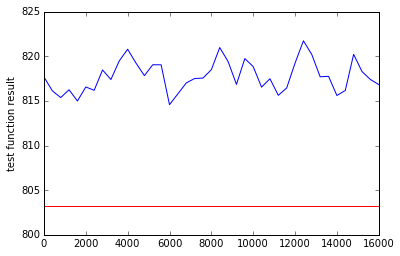

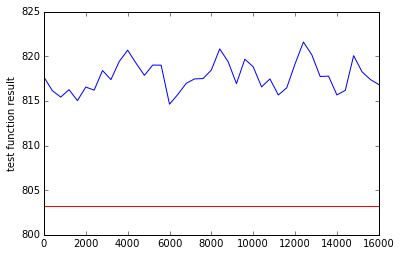

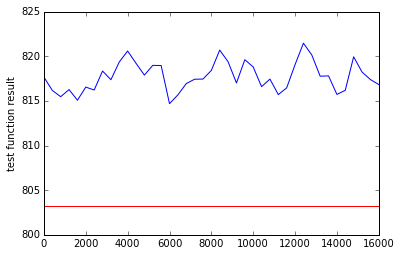

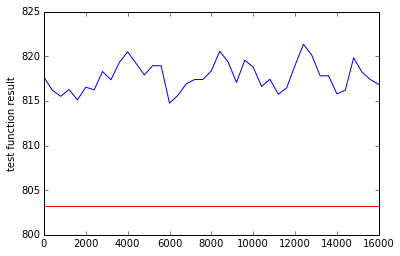

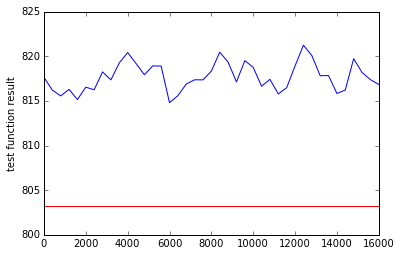

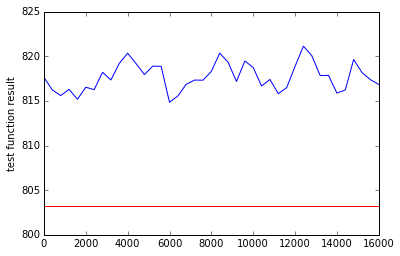

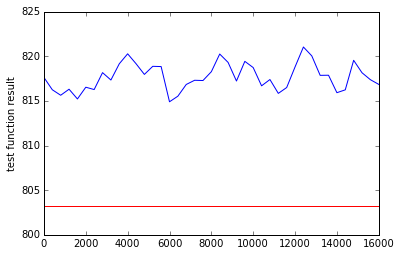

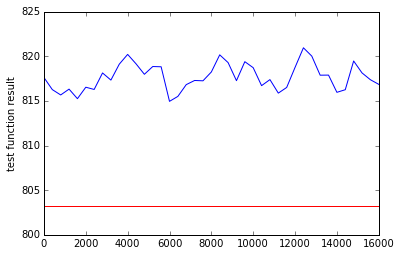

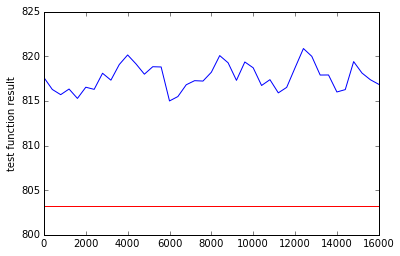

In [14]:
# initialize v0 as a vector drawn uniformly at raondom on the surface of a d-dimensional sphere
d = len(data_set_done[0])
v2 = []
prev_v = [] # record the previous v1 to test convergence
s = 0.0
t = len(data_set_done) # t is the data set lenght: how many data points there are
learning_rate = 1.0

# random intialize a vector from a d-dim sphere
for i in range(0,d):
    tmp = np.random.random()
    s = s + tmp**2
    v2.append(tmp)
    prev_v.append(0.0)

s = math.sqrt(s)
# normalize v1 
for i in range(0,d):
    v2[i] = v2[i] * 1.0/ s

dis = 0.0
loop = 0.0
# test convergence
v2 = np.array([v2]) # v1 type np.array([[x1,x2]]) 
v2 = np.transpose(v2) # let v1 becomese a column major vector
prev_v = v2
testResult = []
tPoint = []

# stil have the infinite problem, need to normalize feature
while True:
    testResult = []
    tPoint = []
    #print "loop is ", loop
    for i in range(0, len(v1_project)/2):
        loop = loop + 1
        learning_rate = 1.0/math.sqrt(loop)
        tmp = v1_project[i] # convert to right form
        #tmp = np.array([tmp])
        b = np.dot(np.transpose(tmp),tmp)
        b = np.dot(b,v2) # result will be a 110 * 1 vector
        v2 = v2 + learning_rate * b 
        v2 = normalizeVector(v2)
        if i % 400 == 0:
            tPoint.append(i)
            test = testFunction2(v1,v2)
            testResult.append(test)
    plt.plot(tPoint, testResult, '-')
    plt.axhline(baseline, color='r')
    plt.ylabel('test function result')
    plt.show()
    dis = distance(prev_v,v2)
    if dis <= 0.001:
            break
    prev_v = v2

In [69]:
# put all the data into the new list where each data is subtract with the projection
v2_project = []
for i in range(0, len(data_set_done)):
    v2_project.append(np.array(data_set_done[i]) 
                      - np.dot(v1.reshape(1,110)[0], data_set_done[i]) * v1.reshape(1,110) 
                      - np.dot(v2.reshape(1,110)[0], data_set_done[i]) * v2.reshape(1,110))


In [78]:
# A general test function that takes array of v and calculates 
# the sum of distance between X and (v, X)* v
 
def testFunction_general(array_of_v):
    total = 0.0
    for item in data_set_done:
        tmp = np.array([item])
        result = np.dot(tmp, array_of_v[0]) * array_of_v[0]
        for index in range(1, len(array_of_v)):
            result += np.dot(tmp, array_of_v[index]) * array_of_v[index]
        total = total + distance(tmp, result)**2
    return total

In [82]:
X1 = np.array([V[0]])
X2 = np.array([V[1]])
X3 = np.array([V[2]])
#print testFunction2(np.transpose(X))
X1.reshape(110,1) #Convert to a correct matrix type for the test function
X2.reshape(110,1)
X3.reshape(110,1)    
# Need transpose because our test function use row vector instead of column vector
baseline = testFunction_general([np.transpose(X1), np.transpose(X2), np.transpose(X3)])
print "with two eigenvector, the new baseline is ", baseline

with two eigenvector, the new baseline is  692.507985195


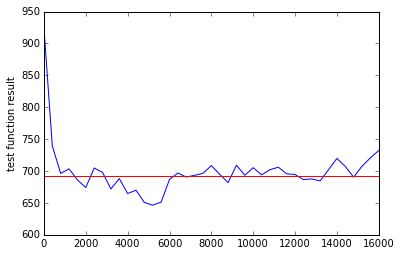

1.35152477322


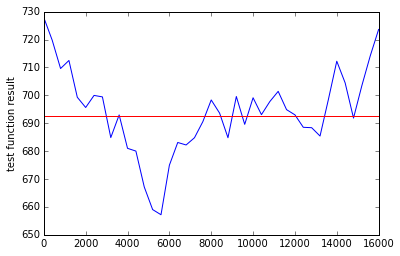

0.0386326856146


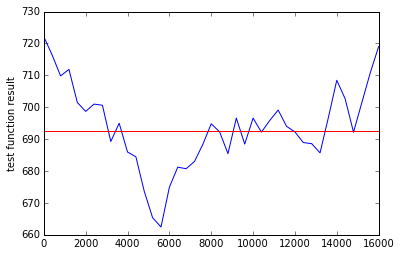

0.0219958123748


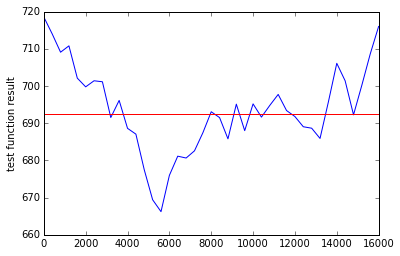

0.0152621543232


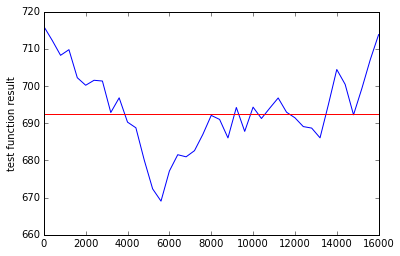

0.0115734183326


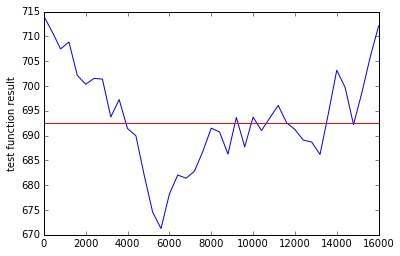

0.00924368469275


In [83]:
# For 3 eigenvector
# initialize v0 as a vector drawn uniformly at raondom on the surface of a d-dimensional sphere
d = len(data_set_done[0])
v3 = []
prev_v = [] # record the previous v1 to test convergence
s = 0.0
t = len(data_set_done) # t is the data set lenght: how many data points there are
learning_rate = 1.0

# random intialize a vector from a d-dim sphere
for i in range(0,d):
    tmp = np.random.random()
    s = s + tmp**2
    v3.append(tmp)
    prev_v.append(0.0)

s = math.sqrt(s)
# normalize v1 
for i in range(0,d):
    v3[i] = v3[i] * 1.0/ s

dis = 0.0
loop = 0.0
# test convergence
v3 = np.array([v3]) # v1 type np.array([[x1,x2]]) 
v3 = np.transpose(v3) # let v1 becomese a column major vector
prev_v = v3
testResult = []
tPoint = []

# stil have the infinite problem, need to normalize feature
while True:
    testResult = []
    tPoint = []
    #print "loop is ", loop
    for i in range(0, len(v2_project)/2):
        loop = loop + 1
        learning_rate = 1.0/math.sqrt(loop)
        tmp = v2_project[i] # convert to right form
        #tmp = np.array([tmp])
        b = np.dot(np.transpose(tmp),tmp)
        b = np.dot(b,v3) # result will be a 110 * 1 vector
        v3 = v3 + learning_rate * b 
        v3 = normalizeVector(v3)
        if i % 400 == 0:
            tPoint.append(i)
            test = testFunction_general([v1,v2,v3])
            testResult.append(test)
    plt.plot(tPoint, testResult, '-')
    plt.axhline(baseline, color='r')
    plt.ylabel('test function result')
    plt.show()
    dis = distance(prev_v,v3)
    print dis
    if dis <= 0.01:
        break
    prev_v = v3

In [70]:
from numpy import linalg
total_energy = 0.0
# Loop through the data set and get norm of each data point to calculate the total energy
for d in data_set_done:
    total_energy += linalg.norm(np.array(d))
print "Total energy is ", total_energy

Total energy is  102168.232902


In [71]:
# This is the part where only 1 eigenvector is presented, the energy for the projection are
v1_energy = 0.0
for d in v1_project:
    v1_energy += linalg.norm(d)
print "Total energy is ", v1_energy

Total energy is  71172.2569324


In [72]:
v2_energy = 0.0
for d in v2_project:
    v2_energy += linalg.norm(d)
print "Total energy is ", v2_energy

Total energy is  63474.7350883


In [86]:
# put all the data into the new list where each data is subtract with the projection
v3_project = []
for i in range(0, len(data_set_done)):
    v3_project.append(np.array(data_set_done[i]) 
                      - np.dot(v1.reshape(1,110)[0], data_set_done[i]) * v1.reshape(1,110) 
                      - np.dot(v2.reshape(1,110)[0], data_set_done[i]) * v2.reshape(1,110)
                      - np.dot(v3.reshape(1,110)[0], data_set_done[i]) * v3.reshape(1,110))

v3_energy = 0.0
for d in v3_project:
    v3_energy += linalg.norm(d)
print "Total energy is ", v3_energy

Total energy is  60212.9483692


In [73]:
SVD1_energy = 0.0
X1 = np.array([V[0]])
for d in data_set_done:
    SVD1_energy += linalg.norm(np.array(d) - np.dot(X1.reshape(1,110)[0], d) * X1.reshape(1,110))
print SVD1_energy

71087.0627767


In [74]:
X1 = np.array([V[0]])
X2 = np.array([V[1]])
SVD2_energy = 0.0
for d in data_set_done:
    SVD2_energy += linalg.norm(np.array(d) 
                      - np.dot(X1.reshape(1,110)[0], d) * X1.reshape(1,110) 
                      - np.dot(X2.reshape(1,110)[0], d) * X2.reshape(1,110))
print SVD2_energy

63357.9101646


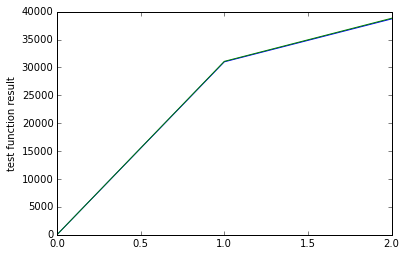

In [75]:
energy_point = [0, total_energy - v1_energy, total_energy-v2_energy]
base_energy_point = [0, total_energy - SVD1_energy, total_energy - SVD2_energy]
k_point = [0, 1, 2]
plt.plot(k_point, energy_point, '-')
plt.plot(k_point, base_energy_point, '-')
#plt.axhline(total_energy, color='r')
plt.ylabel('test function result')
plt.show()

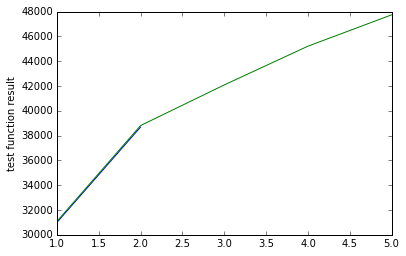

In [115]:
energy_point = [total_energy - 71172.2569324, total_energy-63474.7350883]
base_energy_point = []
for s in SVD_energy_array:
    base_energy_point.append(total_energy - s)
k_point = range(1, 6)
plt.plot([1,2], energy_point, '-')
plt.plot(k_point, base_energy_point, '-')
# plt.axhline(total_energy, color='r')
plt.ylabel('test function result')
plt.show()

with 2 eigenvector, the new baseline is  803.234732097


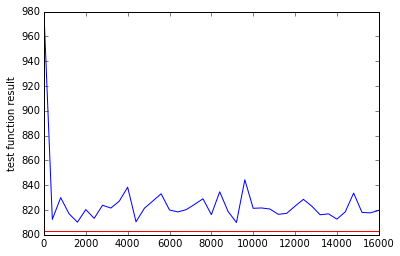

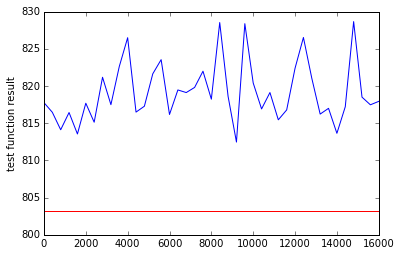

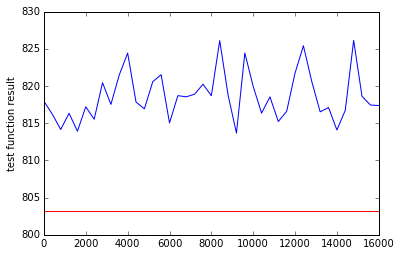

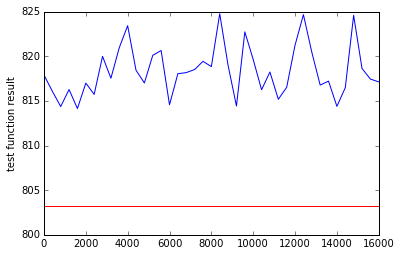

with 3 eigenvector, the new baseline is  692.507985195


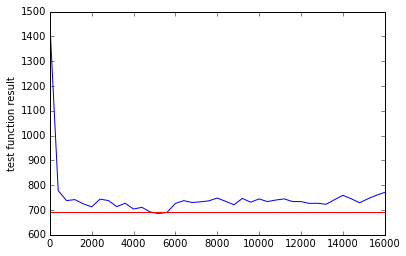

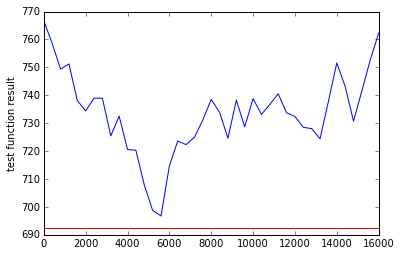

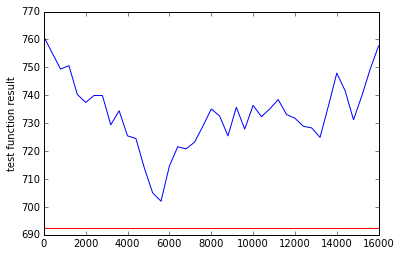

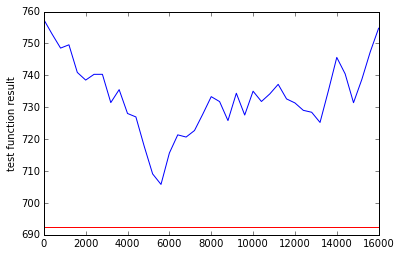

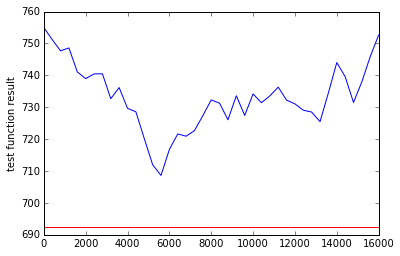

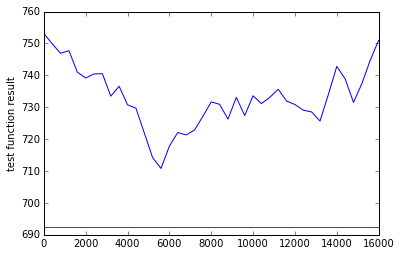

with 4 eigenvector, the new baseline is  652.864287989


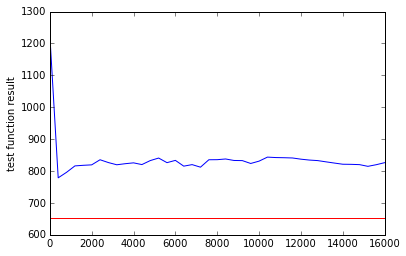

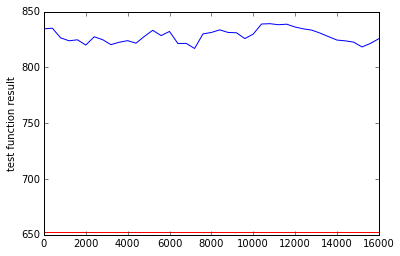

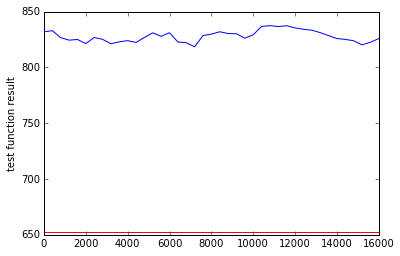

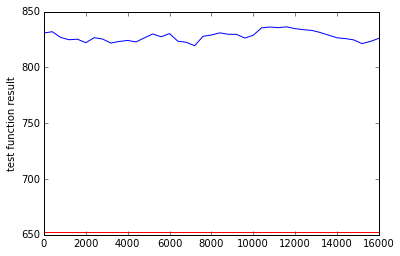

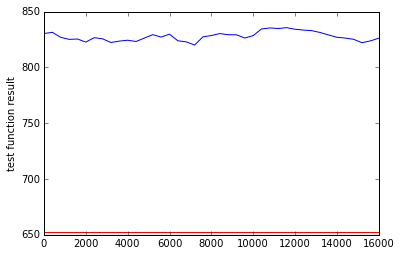

with 5 eigenvector, the new baseline is  614.112889071


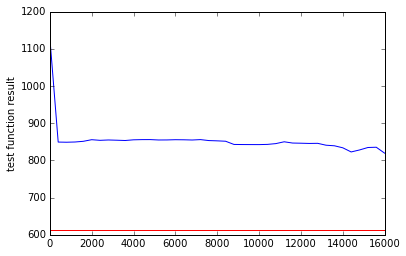

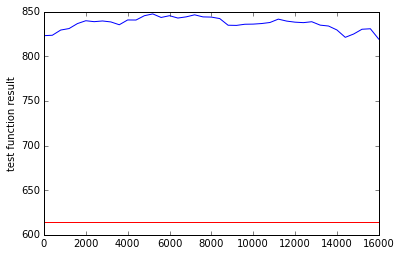

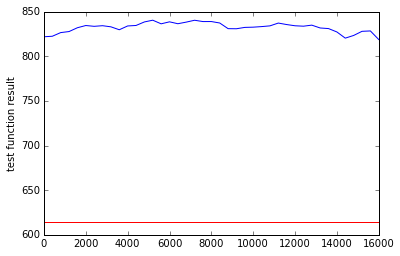

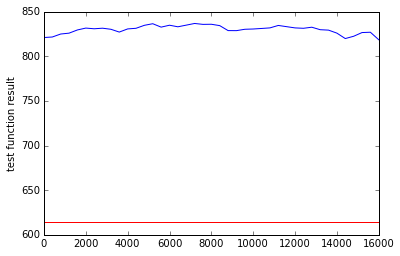

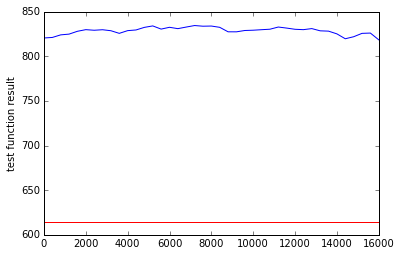

In [110]:
k = 5


# Assume the first eigenvector is already been calculated
# loop through and each loop will yield the next eigenvector
V_vector = []
V_vector.append(v1)
new_projection = []
# put all the data into the new list where each data is subtract with the projection
for i in range(0, len(data_set_done)): 
    new_projection.append(np.array(data_set_done[i]) - np.dot(v1.reshape(1,110)[0], data_set_done[i]) * v1.reshape(1,110))

for global_index in range(1, 5):  
    input_array = []
    for i in range(0, global_index + 1):
        X = np.array([V[i]])
        X.reshape(110,1)
        input_array.append(np.transpose(X))
    baseline = testFunction_general(input_array)
    print "with %d eigenvector, the new baseline is " % (global_index + 1), baseline
    # initialize v0 as a vector drawn uniformly at raondom on the surface of a d-dimensional sphere
    d = len(data_set_done[0])
    v2 = []
    prev_v = [] # record the previous v1 to test convergence
    s = 0.0
    t = len(data_set_done) # t is the data set lenght: how many data points there are
    learning_rate = 1.0

    # random intialize a vector from a d-dim sphere
    for i in range(0,d):
        tmp = np.random.random()
        s = s + tmp**2
        v2.append(tmp)
        prev_v.append(0.0)

    s = math.sqrt(s)
    # normalize v1 
    for i in range(0,d):
        v2[i] = v2[i] * 1.0/ s

    dis = 0.0
    loop = 0.0
    # test convergence
    v2 = np.array([v2]) # v1 type np.array([[x1,x2]]) 
    v2 = np.transpose(v2) # let v1 becomese a column major vector
    prev_v = v2
    testResult = []
    tPoint = []

    # stil have the infinite problem, need to normalize feature
    while True:
        testResult = []
        tPoint = []
        #print "loop is ", loop
        for i in range(0, len(new_projection)/2):
            loop = loop + 1
            learning_rate = 1.0/math.sqrt(loop)
            tmp = new_projection[i] # convert to right form
            #tmp = np.array([tmp])
            b = np.dot(np.transpose(tmp),tmp)
            b = np.dot(b,v2) # result will be a 110 * 1 vector
            v2 = v2 + learning_rate * b 
            v2 = normalizeVector(v2)
            if i % 400 == 0:
                tPoint.append(i)
                input_array = []
                for vs in V_vector:
                    input_array.append(vs)
                input_array.append(v2)
                test = testFunction_general([v1, v2])
                testResult.append(test)
        plt.plot(tPoint, testResult, '-')
        plt.axhline(baseline, color='r')
        plt.ylabel('test function result')
        plt.show()
        dis = distance(prev_v,v2)
        if dis <= 0.01:
                break
        prev_v = v2
    V_vector.append(v2)
    # End of for loop, reach here when the vector has converged
    # put all the data into the new list where each data is subtract with the projection
    new_projection = []
    for i in range(0, len(data_set_done)):
        result = np.array(data_set_done[i]) 
        for j in range(0, global_index+1):
            result = result - np.dot(V_vector[j].reshape(1,110)[0], data_set_done[i]) * V_vector[j].reshape(1,110)
        new_projection.append(result)


In [111]:
print V_vector

[array([[  1.92763688e-001],
       [  7.90675191e-003],
       [  4.16799113e-002],
       [  3.30870786e-001],
       [  1.30054321e-002],
       [  1.62687878e-002],
       [  2.05979453e-002],
       [  9.75755529e-003],
       [  2.87440194e-005],
       [  8.24754563e-009],
       [  5.60590016e-002],
       [  6.48050070e-002],
       [  1.55900820e-001],
       [  1.48649191e-002],
       [  2.10781823e-002],
       [  1.31012120e-002],
       [  8.56985186e-002],
       [  1.51236952e-002],
       [  3.00604148e-002],
       [  1.16799509e-002],
       [  3.15972039e-003],
       [  1.19478495e-002],
       [  1.62404158e-003],
       [  7.34460097e-003],
       [  1.26544650e-003],
       [  9.20604288e-008],
       [  2.46145121e-003],
       [  2.76688563e-001],
       [  1.52372445e-001],
       [  2.00539215e-001],
       [  5.16242293e-002],
       [  4.91578081e-003],
       [  1.49737923e-002],
       [  1.30634074e-006],
       [  1.56891524e-002],
       [  4.4827418

In [139]:
SVD_energy_array = []
for i in range(1, 41):
    SVD_energy = 0.0
    for d in data_set_done:
        input_val = np.array(d)
        for j in range(0, i):
            input_val = input_val - np.dot(np.array([V[j]]).reshape(1,110)[0], d) * np.array([V[j]]).reshape(1,110)
        SVD_energy += linalg.norm(input_val)
    SVD_energy_array.append(SVD_energy)
    print "%d eigenvectors, the energy is " % i, SVD_energy
    print "percentage compressed is %f%%" % ((total_energy-SVD_energy) / total_energy * 100.0)

1 eigenvectors, the energy is  71087.0627767
percentage compressed is 30.421560%
2 eigenvectors, the energy is  63357.9101646
percentage compressed is 37.986683%
3 eigenvectors, the energy is  60079.3058195
percentage compressed is 41.195708%
4 eigenvectors, the energy is  56955.0831922
percentage compressed is 44.253628%
5 eigenvectors, the energy is  54426.8590755
percentage compressed is 46.728198%
6 eigenvectors, the energy is  51911.0448924
percentage compressed is 49.190621%
7 eigenvectors, the energy is  49574.1808268
percentage compressed is 51.477891%
8 eigenvectors, the energy is  47520.9711217
percentage compressed is 53.487528%
9 eigenvectors, the energy is  45768.8870272
percentage compressed is 55.202429%
10 eigenvectors, the energy is  44056.5414628
percentage compressed is 56.878435%
11 eigenvectors, the energy is  42273.2263735
percentage compressed is 58.623904%
12 eigenvectors, the energy is  40453.0735451
percentage compressed is 60.405429%
13 eigenvectors, the ener

In [137]:
energy_array = []
for i in range(1, 6):
    energy = 0.0
    for d in data_set_done:
        input_val = np.array(d)
        for j in range(0, i):
            input_val = input_val - np.dot(np.array([V_vector[j]]).reshape(1,110)[0], d) * np.array([V_vector[j]]).reshape(1,110)
        energy += linalg.norm(input_val)
    energy_array.append(energy)
    print "%d eigenvectors, the energy is " % i, energy
    print "percentage compressed is %f%%" % ((total_energy-energy) / total_energy * 100.0)

1 eigenvectors, the energy is  71172.2569324
percentage compressed is 30.338174%
2 eigenvectors, the energy is  63499.2929736
percentage compressed is 37.848301%
3 eigenvectors, the energy is  60241.0704667
percentage compressed is 41.037377%
4 eigenvectors, the energy is  57140.3661104
percentage compressed is 44.072277%
5 eigenvectors, the energy is  54565.6122548
percentage compressed is 46.592389%


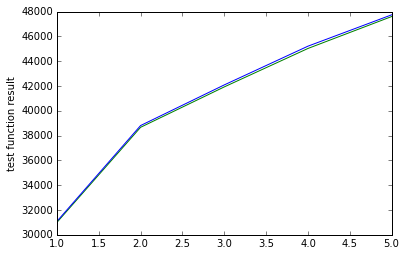

In [122]:
energy_point = []
base_energy_point = []
for e in energy_array:
    energy_point.append(total_energy-e)
base_energy_point = []
for s in SVD_energy_array:
    base_energy_point.append(total_energy - s)
k_point = range(1, 6)
plt.plot(k_point, energy_point, '-',color="green")
plt.plot(k_point, base_energy_point, '-',color="blue")
# plt.axhline(total_energy, color='r')
plt.ylabel('test function result')
plt.show()